# Self-consistent evaluation of summarization using LLMs

- Continued from first experiments with WikiHow in `llm-self-con-eval`

## Update :

Trying with [https://huggingface.co/datasets/jordiclive/wikipedia-summary-dataset](https://huggingface.co/datasets/jordiclive/wikipedia-summary-dataset) dataset.

Also try with [https://huggingface.co/datasets/knkarthick/samsum](https://huggingface.co/datasets/knkarthick/samsum) SAMSum

- try to get samples with 4-5 summary facts, so combinatorics goes faster
- CARE! for SAMSum lots of summaries with only 1 fact, so filter on those having more than 2-3.

---

- Code below with `"microsoft/Phi-3-mini-4k-instruct"` runs on GPU P100
- Using basic settings for Microsoft Phi-3 from: [https://github.com/microsoft/Phi-3CookBook/blob/main/md/02.QuickStart/Huggingface_QuickStart.md](https://github.com/microsoft/Phi-3CookBook/blob/main/md/02.QuickStart/Huggingface_QuickStart.md)

## TODO

- Different models
- Different datasets: [https://huggingface.co/datasets/csebuetnlp/xlsum/viewer/english](https://huggingface.co/datasets/csebuetnlp/xlsum/viewer/english)
- Different prompts: currently not doing templated/extraction prompt, free prompt seems to give desired format for outputs
- Improve parsing functions: 1) converting scores to ints from the completions 2) splitting components of gold dataset summary into individual summary facts

In [1]:
import time
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from itertools import combinations
from random import sample, seed

2024-07-03 20:43:59.437617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 20:43:59.437720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 20:43:59.564651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed(1729)
torch.random.manual_seed(0)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [3]:
#model_checkpoint = "microsoft/Phi-3-medium-4k-instruct"
model_checkpoint = "microsoft/Phi-3-mini-4k-instruct" # RUNS ON Kaggle GPU P100

model = AutoModelForCausalLM.from_pretrained(
    model_checkpoint, 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Temperature settings for experiments

- Set 0 for all experiments so far

In [4]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

# Set temperature to 0 for experiment
generation_args = {
    "max_new_tokens": 600,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

# Dataset

- Using `jordiclive/wikipedia-summary-dataset` and/or `https://huggingface.co/datasets/knkarthick/samsum`
- This is a wikipediaSummary dataset variant it seems
- SAMSum is a kind of whatsapp conversation

**CARE! SAMSum has short summaries - will filter to find those with > 2-3 summary facts**

## SAMSum format for summary facts

- Summary facts are separated by periods:

```
Elisa, Sadie, Carol, Liam, Tom and John want to go for drinks tonight at Mombasa. Arthur will come with Alice. Kai will join them around 8. Elisa will book the big corner table for 15 people.
```

In [5]:
ds = load_dataset("knkarthick/samsum") # couldn't get preview of real SAMSum, do it later with "official" dataset

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

## Functions

- Made a quick "prompt template" function, avoid importing heavy frameworks etc.
- Split summary (a single sentence, string) into a list of `num_facts_in_summary` individual facts

## Update for different dataset

- SAMSum has this in description of dataset construction : **Each dialogue was created by one person. After collecting all of the conversations, we asked language experts to annotate them with summaries, assuming that they should (1) be rather short, (2) extract important pieces of information, (3) include names of interlocutors, (4) be written in the third person. Each dialogue contains only one reference summary.** 
- So I will write a `get_samsum_prompt()` that prompts around this requirement

In [12]:
def get_samsum_prompt(samsum_text, curr_summary):
    
    samsum_system_prompt = "You are a helpful assistant who evaluates the quality of short summaries of conversations between 2 or more people."

    samsum_user_prompt = f"""Here is the full text of a internet chat conversation between 2 or more interlocutors. Each sentence in the conversation will begin with the corresponding interlocutor's name. This is followed by a concise summary of the conversation. Give a score, from 1 to 5, of the quality of the summary: if the summary extracts all of the essential information from the conversation, and correctly records the names of the interlocutors and their roles, give a score of 5. If the summary does not extract any information is important from the article, or if the summary makes mistakes about the activities of the interlocutors, give a score of 1.

    ### Conversation Full Text ###
    {samsum_text}
    
    ### Conversation Summary ###
    {curr_summary}

    Give your answer in the following format, without deviation:

    Score: your score, an integer value between 1 and 5.
    Explanation: a short explanation of your Score.
    Missing Information: if your score is not 5, give the most important information that the summary missed from the conversation."""
    
    return samsum_system_prompt, samsum_user_prompt


def split_samsum_summary_for_combinations(summary: str, split_str='.'):
    summary_sentences = [x.rstrip(' ').lstrip(' ').rstrip(' .') for x in summary.split(split_str) if x]
    summary_sentences = [x for x in summary_sentences if x != '']

    return summary_sentences


def get_score_to_int(row):
    """
    Parse the "score" value from the row completion:

    Note that so far with Phi3 the prompt formatting is consistent so don't need to try/except stuff
    so just get the "number that is after Score: " basically O_o
    """
    # "Score: n......"
    # n is in index 7 <--- UPDATE IT IS IN 8!?!??! MAYBE DOUBLE SPACE I CAN'T SEE
    # TODO: make this safer/error handle O_o
    return int(row["completion"][8])

# Experiments

- For now, only sending 1 single example (i.e. a pair (text, gold summary of text))
- TODO: will need to modify logic for the dataframe / plotting steps, as will need to groupby on the "id" of the examples, and plot a graph for each individually (since concatenating all results across all examples to the same final dataframe)

### SAMSum dataset - filter on longer summaries

Lots only contain 1 summary fact

In [13]:
good_examples = []

for example in ds["train"]:
    summary_sentences = split_samsum_summary_for_combinations(example["summary"])
    
    if len(summary_sentences) > 3:
        print(summary_sentences)
        good_examples.append(example)
        if len(good_examples) > 4:
            break
        
good_examples

['Aria has just run into Charlie Evans', 'He is now married, with two daughters, and a family business', 'She has also met Cooper Roy from high school', "She used to have a crush on him, now she almost didn't recognise him", 'Maverick and Aria miss the old times and think the world has changed for the worse']
['Layla the dog misses Rachel', 'She is having a knee surgery, because of arthritis', 'Renee sends a picture of her dog', "Rachel getting settled and she's looking for a job in teaching"]
['Elisa, Sadie, Carol, Liam, Tom and John want to go for drinks tonight at Mombasa', 'Arthur will come with Alice', 'Kai will join them around 8', 'Elisa will book the big corner table for 15 people']
["Ray's bike was stolen from the 9th street yesterday even though it was secured", "It was a custom bike so now Ray's out few grand", "Ray wants to post posters in the area so they'll get scared and leave it somewhere", 'Luke had one stolen last month from the same area', 'Sam wants to help out']
['

[{'id': '13828741',
  'dialogue': "Aria: You won't believe who I've just met!\nAria: Charlie Evans!\nMaverick: Oh God, I haven't seen him from ages!\nMaverick: How is he doing?\nAria: He's doing great. :)\nAria: He got married, he runs a small family business, which he is very passionate about and generally he seems to be a happy and fulfilled man. :)\nAria: Oh, and he has two absolutely adorable daughters. :)\nAria: It was so nice to meet him, he's such a sweet soul.\nMaverick: I’m glad to hear that. :)\nMaverick: Time flies so fast, doesn't it?\nAria: It does. :) Recently I’ve met Cooper Roy, I'm sure you remember him, I constantly talked about him back then in high school, because I had a huge crush on him. He’s changed a lot!\nAria: I barely recognized him!\nMaverick: I remember, how you and Kylie used to gossip about him all the time. :)\nAria: Well, we were madly in love with him.\nAria: Or at least we thought so. ;)\nMaverick: I sometimes miss those times.\nMaverick: Everything 

In [14]:
good_examples[0]

{'id': '13828741',
 'dialogue': "Aria: You won't believe who I've just met!\nAria: Charlie Evans!\nMaverick: Oh God, I haven't seen him from ages!\nMaverick: How is he doing?\nAria: He's doing great. :)\nAria: He got married, he runs a small family business, which he is very passionate about and generally he seems to be a happy and fulfilled man. :)\nAria: Oh, and he has two absolutely adorable daughters. :)\nAria: It was so nice to meet him, he's such a sweet soul.\nMaverick: I’m glad to hear that. :)\nMaverick: Time flies so fast, doesn't it?\nAria: It does. :) Recently I’ve met Cooper Roy, I'm sure you remember him, I constantly talked about him back then in high school, because I had a huge crush on him. He’s changed a lot!\nAria: I barely recognized him!\nMaverick: I remember, how you and Kylie used to gossip about him all the time. :)\nAria: Well, we were madly in love with him.\nAria: Or at least we thought so. ;)\nMaverick: I sometimes miss those times.\nMaverick: Everything se

## Using one single example for setting up scripts

I picked example at index `0` in the list above - it has several people mentioned by name so seems representative and complex-enough for behavior to be interesting

---

# IMPORTANT !

**CARE!** I noticed while reading output on first seconds of running the script that, due to how dataset is built, the summary sentences number 2,3,4... may contain references to entities in previous sentences.

- Example: "Bob went to McDonalds. He is hungry"

If you were to send "He is hungry" as a single fact, you would be penalized due to the He being ambiguous. So I did a **manual rewrite of the single example used in the experiment below, by making each single split sentence/fact be "independent" i.e. remove co-references etc.**

- TODO: maybe can automate this with basic NLP / entity detection

**NOTE ALSO: I removed words such as "Also / As well as / Consequently" which refer to a previous sentence**


In [17]:
EXPERIMENTS_DATASET_TRAIN_INDICES = [0] # 44,45,3115 etc, for now only 1

for example_idx in EXPERIMENTS_DATASET_TRAIN_INDICES:
    samsum_example = good_examples[example_idx]
    

    
    print(f"**** EXPERIMENT WITH {samsum_example['dialogue']} ****")
    print("***" * 30)
    
    
    # TODO -- NOTICED WHEN STARTING EXPERIMENT THAT SUBSEQUENT SENTENCES HAVE CO-REFERENCES
    # I WILL REWRITE MANUALLY SO THAT INDIVIDUAL SENTENCES OUT OF CONTEXT MAKE SENSE
    # REMOVED WORDS LIKE "ALSO, AS WELL AS" ETC
    #facts_from_summary = split_samsum_summary_for_combinations(samsum_example["summary"])
    facts_from_summary = ['Aria has just run into Charlie Evans',
     'Charlie Evans is now married, with two daughters, and a family business',
     'Aria has met Cooper Roy from high school',
     "Aria used to have a crush on Cooper Roy, now she almost didn't recognise him",
     'Maverick and Aria miss the old times and think the world has changed for the worse']
    num_facts_total = len(facts_from_summary)
    
    # TODO: improve if need better performance when larger summaries
    num_facts_sampler = list(range(1, num_facts_total + 1))

    # save results to rows[] for later processing
    rows = []

    start_time = time.time()

    for num_facts_to_include in num_facts_sampler:
        print(f"==== PROCESSING EXAMPLES CONSISTING OF : {num_facts_to_include} FACTS ====")
        
        # Generate all combinations of facts:
        all_combs = list(combinations(facts_from_summary, num_facts_to_include))
        # ... then sample from them, else will timeout O_o

        # TODO: improve, maybe take more combos for the intermediate values of 'k'
        number_of_combos_to_sample = min(len(all_combs), 2 * num_facts_total)
        it = sample(all_combs, number_of_combos_to_sample)

        for selected_facts in it:
            # produce the article summary from these selected_facts
            # currently join with '. ' so that format is same as original SAMSum dataset
            JOIN_CHAR_SAMSUM = '. '
            curr_summary = JOIN_CHAR_SAMSUM.join(selected_facts)
            curr_text = samsum_example["dialogue"]

            print("PROCESSING : ", curr_summary)

            # send this to model
            system_prompt, user_prompt = get_samsum_prompt(curr_text, curr_summary)
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ]
            res = pipe(messages, **generation_args)

            rows.append({
                "example_index_in_dataset": samsum_example["id"],
                "num_facts": num_facts_to_include,
                "selected_facts": selected_facts,
                "completion": res[0]['generated_text'],
            })        

    end_time = time.time()
    
print("TOTAL TIME TAKEN : ", end_time - start_time)

**** EXPERIMENT WITH Aria: You won't believe who I've just met!
Aria: Charlie Evans!
Maverick: Oh God, I haven't seen him from ages!
Maverick: How is he doing?
Aria: He's doing great. :)
Aria: He got married, he runs a small family business, which he is very passionate about and generally he seems to be a happy and fulfilled man. :)
Aria: Oh, and he has two absolutely adorable daughters. :)
Aria: It was so nice to meet him, he's such a sweet soul.
Maverick: I’m glad to hear that. :)
Maverick: Time flies so fast, doesn't it?
Aria: It does. :) Recently I’ve met Cooper Roy, I'm sure you remember him, I constantly talked about him back then in high school, because I had a huge crush on him. He’s changed a lot!
Aria: I barely recognized him!
Maverick: I remember, how you and Kylie used to gossip about him all the time. :)
Aria: Well, we were madly in love with him.
Aria: Or at least we thought so. ;)
Maverick: I sometimes miss those times.
Maverick: Everything seemed to be easier, better an

## TODO: modify this when you run more than 1 example in an experiment

- Currently assumes dataframe has only 1 distinct "experiment id"

In [18]:
df = pd.DataFrame(rows)
df["score"] = df.apply(get_score_to_int, axis=1)
simple_df = df[["num_facts", "score"]]

In [19]:
simple_df.head()

,num_facts,score
0,1,3
1,1,3
2,1,3
3,1,2
4,1,3


# Plot results for each example sent to LLM

/tmp/ipykernel_34/3567036239.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = g

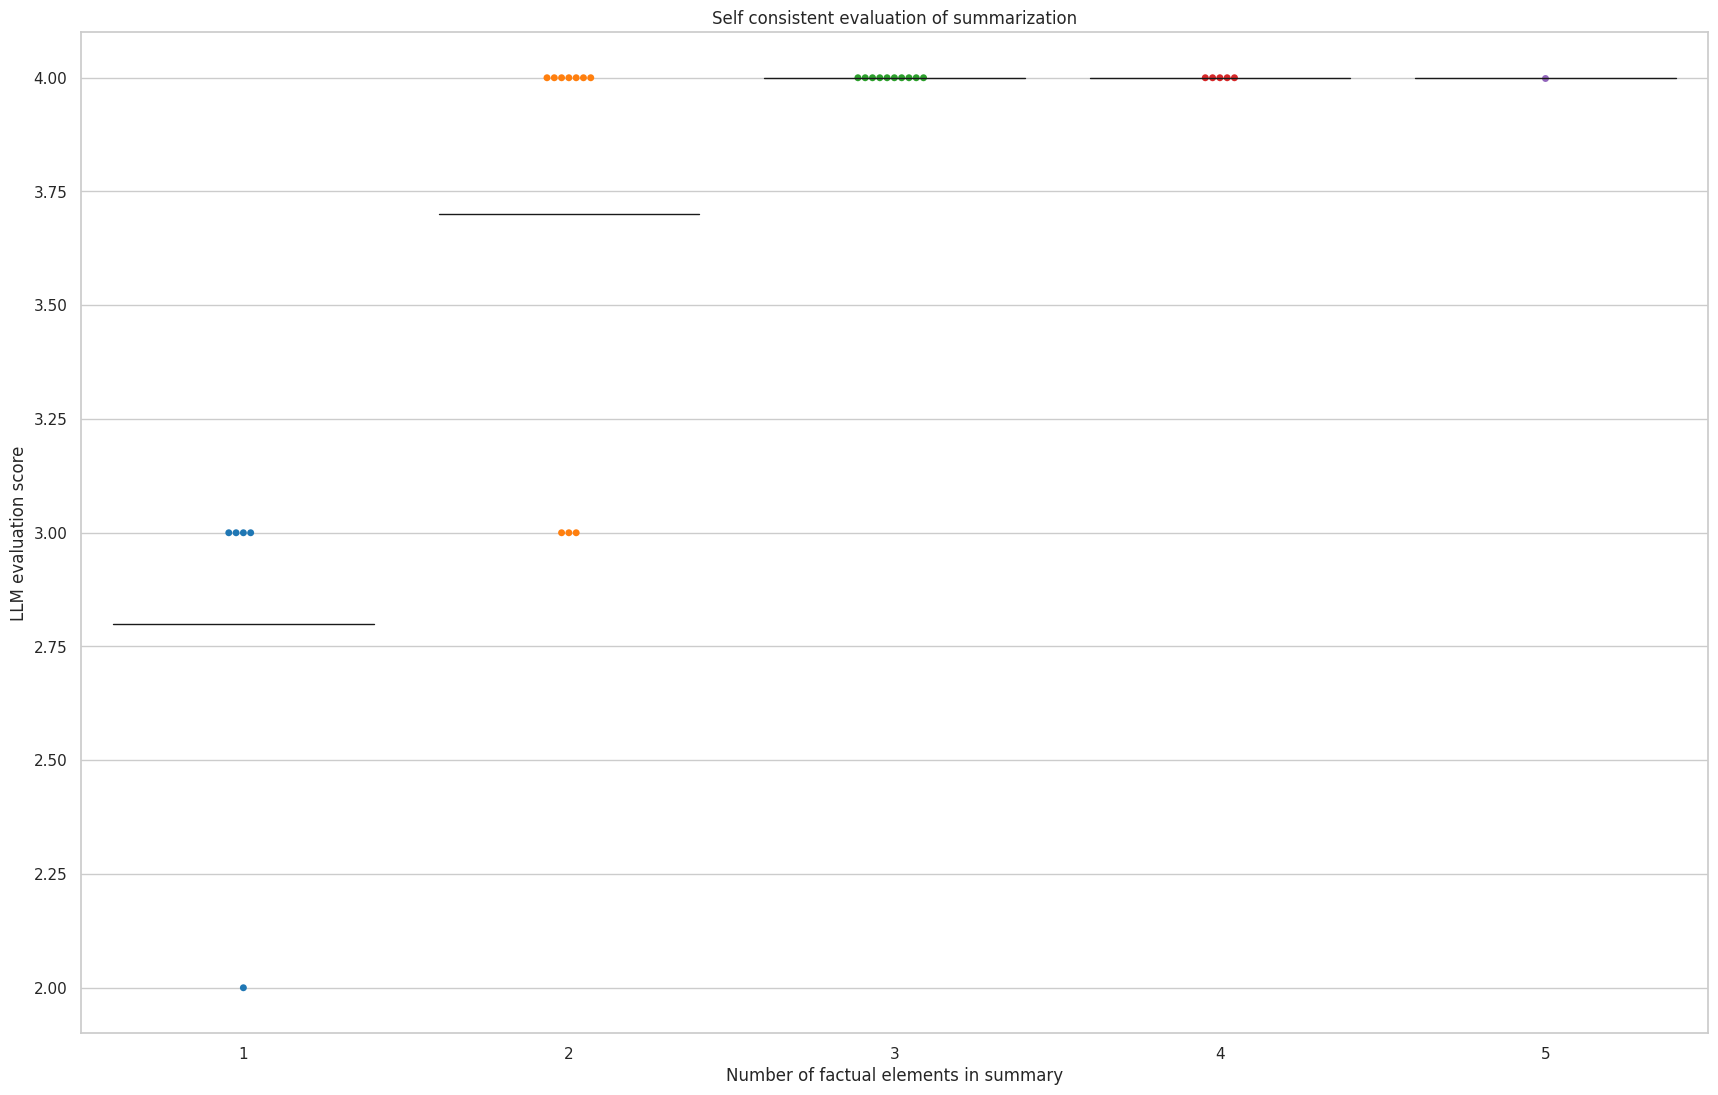

In [20]:
sns.set(style='whitegrid')

# Code from:
# https://stackoverflow.com/questions/67481900/how-to-add-a-mean-line-to-a-seaborn-stripplot-or-swarmplot
# note: need to adjust size if have more points else they don't fit in swarmplot O_o
plt.figure(figsize=(21, 13))
p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")

ax=sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="num_facts",
            y="score",
            data=simple_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

plt.title('Self consistent evaluation of summarization')
ax.set_ylabel("LLM evaluation score")
ax.set_xlabel("Number of factual elements in summary")
plt.show()

In [22]:
import json

with open('llm-self-con-eval.json', 'w') as fo:
    json.dump(rows, fo, indent=4, ensure_ascii=True)

## Observations and ideas

As noted previously, it's important to see whether it is evaluating:

- factuality
- according to length

So need controls, for example, where you keep the same length but vary the factuality.

Below I do this "manually" for one experiment - I am going to negate facts and swap people around: **can imagine doing this on a spectrum from subtle-errors to obvious-errors also**

Original, **gold**, `facts_from_summary`:

```
facts_from_summary = ['Aria has just run into Charlie Evans',
     'Charlie Evans is now married, with two daughters, and a family business',
     'Aria has met Cooper Roy from high school',
     "Aria used to have a crush on Cooper Roy, now she almost didn't recognise him",
     'Maverick and Aria miss the old times and think the world has changed for the worse']
```

Manually edited `facts_from_summary`:

```
facts_from_summary = ['Aria has just run into Maverick',
     'Charlie Evans is now married, with two daughters and a son, and a family business',
     'Aria is planning to meet Cooper Roy from high school',
     "Aria used to have a crush on Cooper Roy, now she almost didn't recognise him",
     'Charlie Evans, Maverick, and Aria miss the old times and think the world has changed for the worse']
```

In [23]:
EXPERIMENTS_DATASET_TRAIN_INDICES = [0] # 44,45,3115 etc, for now only 1

for example_idx in EXPERIMENTS_DATASET_TRAIN_INDICES:
    samsum_example = good_examples[example_idx]
    

    
    print(f"**** EXPERIMENT WITH {samsum_example['dialogue']} ****")
    print("***" * 30)
    
    
    # TODO -- NOTICED WHEN STARTING EXPERIMENT THAT SUBSEQUENT SENTENCES HAVE CO-REFERENCES
    # I WILL REWRITE MANUALLY SO THAT INDIVIDUAL SENTENCES OUT OF CONTEXT MAKE SENSE
    # REMOVED WORDS LIKE "ALSO, AS WELL AS" ETC
    #facts_from_summary = split_samsum_summary_for_combinations(samsum_example["summary"])
    
    ## --- CARE: THESE ARE THE "MANUALLY ADJUSTED BAD FACTS" --
    facts_from_summary = ['Aria has just run into Maverick',
     'Charlie Evans is now married, with two daughters and a son, and a family business',
     'Aria is planning to meet Cooper Roy from high school',
     "Aria used to have a crush on Cooper Roy, now she almost didn't recognise him",
     'Charlie Evans, Maverick, and Aria miss the old times and think the world has changed for the worse']
    num_facts_total = len(facts_from_summary)
    
    # TODO: improve if need better performance when larger summaries
    num_facts_sampler = list(range(1, num_facts_total + 1))

    # save results to rows[] for later processing
    bad_rows = []

    start_time = time.time()

    for num_facts_to_include in num_facts_sampler:
        print(f"==== PROCESSING EXAMPLES CONSISTING OF : {num_facts_to_include} FACTS ====")
        
        # Generate all combinations of facts:
        all_combs = list(combinations(facts_from_summary, num_facts_to_include))
        # ... then sample from them, else will timeout O_o

        # TODO: improve, maybe take more combos for the intermediate values of 'k'
        number_of_combos_to_sample = min(len(all_combs), 2 * num_facts_total)
        it = sample(all_combs, number_of_combos_to_sample)

        for selected_facts in it:
            # produce the article summary from these selected_facts
            # currently join with '. ' so that format is same as original SAMSum dataset
            JOIN_CHAR_SAMSUM = '. '
            curr_summary = JOIN_CHAR_SAMSUM.join(selected_facts)
            curr_text = samsum_example["dialogue"]

            print("PROCESSING : ", curr_summary)

            # send this to model
            system_prompt, user_prompt = get_samsum_prompt(curr_text, curr_summary)
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ]
            res = pipe(messages, **generation_args)

            bad_rows.append({
                "example_index_in_dataset": samsum_example["id"],
                "num_facts": num_facts_to_include,
                "selected_facts": selected_facts,
                "completion": res[0]['generated_text'],
            })        

    end_time = time.time()
    
print("TOTAL TIME TAKEN : ", end_time - start_time)

**** EXPERIMENT WITH Aria: You won't believe who I've just met!
Aria: Charlie Evans!
Maverick: Oh God, I haven't seen him from ages!
Maverick: How is he doing?
Aria: He's doing great. :)
Aria: He got married, he runs a small family business, which he is very passionate about and generally he seems to be a happy and fulfilled man. :)
Aria: Oh, and he has two absolutely adorable daughters. :)
Aria: It was so nice to meet him, he's such a sweet soul.
Maverick: I’m glad to hear that. :)
Maverick: Time flies so fast, doesn't it?
Aria: It does. :) Recently I’ve met Cooper Roy, I'm sure you remember him, I constantly talked about him back then in high school, because I had a huge crush on him. He’s changed a lot!
Aria: I barely recognized him!
Maverick: I remember, how you and Kylie used to gossip about him all the time. :)
Aria: Well, we were madly in love with him.
Aria: Or at least we thought so. ;)
Maverick: I sometimes miss those times.
Maverick: Everything seemed to be easier, better an

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


PROCESSING :  Aria has just run into Maverick
PROCESSING :  Charlie Evans, Maverick, and Aria miss the old times and think the world has changed for the worse
PROCESSING :  Aria is planning to meet Cooper Roy from high school
PROCESSING :  Charlie Evans is now married, with two daughters and a son, and a family business
==== PROCESSING EXAMPLES CONSISTING OF : 2 FACTS ====
PROCESSING :  Charlie Evans is now married, with two daughters and a son, and a family business. Aria is planning to meet Cooper Roy from high school
PROCESSING :  Aria is planning to meet Cooper Roy from high school. Charlie Evans, Maverick, and Aria miss the old times and think the world has changed for the worse
PROCESSING :  Aria is planning to meet Cooper Roy from high school. Aria used to have a crush on Cooper Roy, now she almost didn't recognise him
PROCESSING :  Aria has just run into Maverick. Charlie Evans is now married, with two daughters and a son, and a family business
PROCESSING :  Charlie Evans is no

In [27]:
bad_df = pd.DataFrame(bad_rows)
bad_df["score"] = bad_df.apply(get_score_to_int, axis=1)
simple_bad_df = bad_df[["num_facts", "score"]]

simple_bad_df.head()

,num_facts,score
0,1,3
1,1,2
2,1,2
3,1,2
4,1,2


/tmp/ipykernel_34/690171279.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_bad_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset 

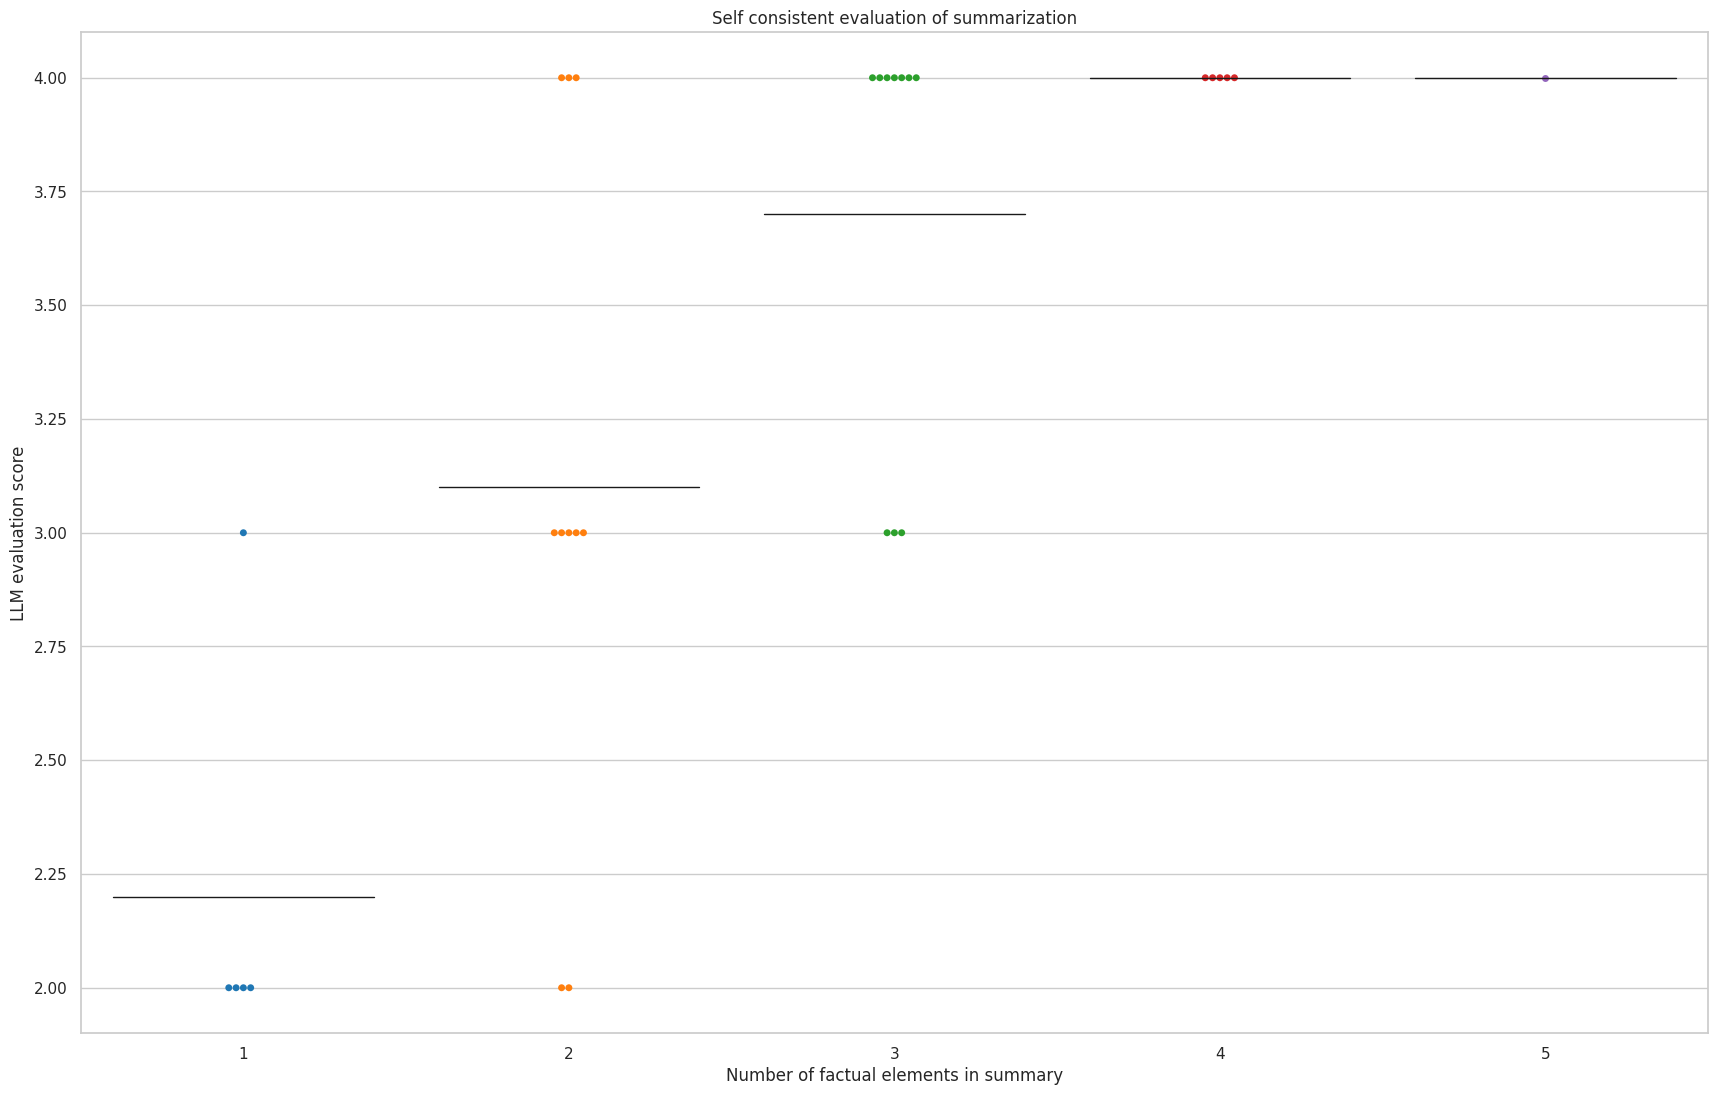

In [30]:
sns.set(style='whitegrid')

# Code from:
# https://stackoverflow.com/questions/67481900/how-to-add-a-mean-line-to-a-seaborn-stripplot-or-swarmplot
# note: need to adjust size if have more points else they don't fit in swarmplot O_o
plt.figure(figsize=(21, 13))
p = sns.swarmplot(x="num_facts", y="score", data=simple_bad_df, size=5, palette="tab10")

ax=sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="num_facts",
            y="score",
            data=simple_bad_df, # <------------ CARE! TODO: NEED TO MODIFY HERE AS WELL : TURN THIS INTO A FUNCTION ELSE KEEP FORGETTING BUG POTENTIAL
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

plt.title('Self consistent evaluation of summarization')
ax.set_ylabel("LLM evaluation score")
ax.set_xlabel("Number of factual elements in summary")
plt.show()

In [29]:
with open('llm-self-con-deliberate-incorrect-facts-eval.json', 'w') as fo:
    json.dump(rows, fo, indent=4, ensure_ascii=True)